In [28]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import importlib
import utils
import attention
import glob

import seaborn as sns
import pandas as pd

In [ ]:
importlib.reload(utils)
importlib.reload(attention)

shuffled_transformer = []
for _ in range(20):
    
    net = attention.SimpleViT(image_size = 32,
        patch_size = 4,
        num_classes = 10,
        dim = 1024,
        depth = 1,
        heads = 16,
        mlp_dim = 2048
    ).cuda()
        
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    trainer = utils.CIFAR_trainer(data_params = dict(
                                    pixel_shuffled = True
                                 ),
                                  train_params = dict(batch_size = 4,
                                      num_epochs = 20),
                model_optim_params = dict(model = net, criterion = criterion, optimizer = optimizer))
    trainer.train()

[1,  2000] loss: 2.066
[1,  4000] loss: 1.919
[1,  6000] loss: 1.880
[1,  8000] loss: 1.858
[1, 10000] loss: 1.827
[1, 12000] loss: 1.799
[2,  2000] loss: 1.746
[2,  4000] loss: 1.741
[2,  6000] loss: 1.723
[2,  8000] loss: 1.711
[2, 10000] loss: 1.700
[2, 12000] loss: 1.666
[3,  2000] loss: 1.648
[3,  4000] loss: 1.636
[3,  6000] loss: 1.618
[3,  8000] loss: 1.610
[3, 10000] loss: 1.576
[3, 12000] loss: 1.596
[4,  2000] loss: 1.559
[4,  4000] loss: 1.556
[4,  6000] loss: 1.554
[4,  8000] loss: 1.554
[4, 10000] loss: 1.540
[4, 12000] loss: 1.531
[5,  2000] loss: 1.505
[5,  4000] loss: 1.514
[5,  6000] loss: 1.509
[5,  8000] loss: 1.502
[5, 10000] loss: 1.498
[5, 12000] loss: 1.498
[6,  2000] loss: 1.459
[6,  4000] loss: 1.468
[6,  6000] loss: 1.466
[6,  8000] loss: 1.473
[6, 10000] loss: 1.473
[6, 12000] loss: 1.469
[7,  2000] loss: 1.424
[7,  4000] loss: 1.427
[7,  6000] loss: 1.447
[7,  8000] loss: 1.430
[7, 10000] loss: 1.447
[7, 12000] loss: 1.441
[8,  2000] loss: 1.400
[8,  4000] 

Number of runs alexnet True 1
Number of runs alexnet False 1
[3.21698040263668] 1
[1.8926814430078882] 1


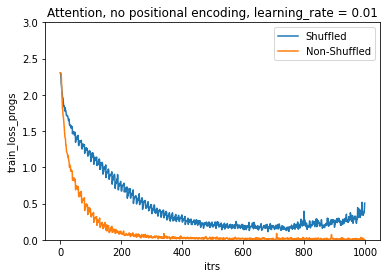

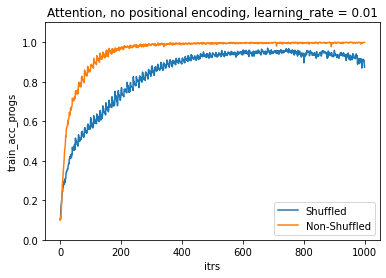

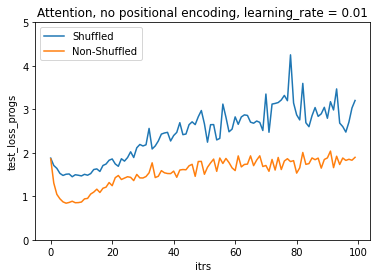

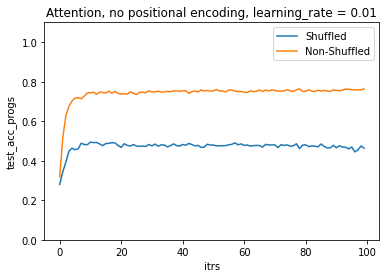

model_True_test_losses [3.21698040263668]
model_False_test_losses [1.8926814430078882]


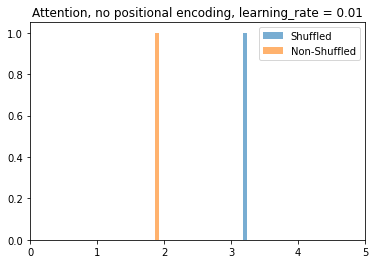

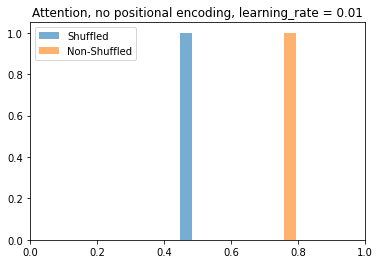

In [58]:
importlib.reload(utils)

def get_record(model_name, shuffled, extra = ""):
    outdir = "/scratch/gpfs/qanguyen/renorm"
    test_losses = []
    test_accs = []
    lrs = []
    itrs = []
    train_loss_progs = []
    train_acc_progs = []
    testlosses_dict = []
    
    test_itrs = []
    test_loss_progs = []
    test_acc_progs = []
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*")[:1]:
        record = utils.load_file_pickle(f)
        itr, train_loss_prog = list(zip(*enumerate(record["metrics"]["train_loss_prog"])))
        if len(itr) > 500:
            test_losses.append(record["metrics"]["test_loss"])
            test_accs.append(record["metrics"]["test_accuracy"])
            itrs.extend(itr)
            train_loss_progs.extend(train_loss_prog)
            testlosses_dict.extend([record["metrics"]["test_loss"]] * len(itr))
            
        itr, train_acc_prog = list(zip(*enumerate(record["metrics"]["train_acc_prog"])))
        if len(itr) > 500:
            train_acc_progs.extend(train_acc_prog)
            
        itr, test_loss_prog = list(zip(*enumerate(record["metrics"]["test_loss_prog"])))
        test_itrs.extend(itr)
        test_loss_progs.extend(test_loss_prog)
        
        itr, test_acc_prog = list(zip(*enumerate(record["metrics"]["test_acc_prog"])))
        test_acc_progs.extend(test_acc_prog)
        
    print("Number of runs", model_name, shuffled, len(test_losses))
    train_df = pd.DataFrame.from_dict(dict(itrs = itrs, 
                                                         train_loss_progs = train_loss_progs, 
                                                         train_acc_progs = train_acc_progs,
                                                         testlosses_dict = testlosses_dict))
    test_df = pd.DataFrame.from_dict(dict(itrs = test_itrs, 
                                                         test_loss_progs = test_loss_progs, 
                                                         test_acc_progs = test_acc_progs))
    return test_losses, test_accs, lrs, train_df, test_df
    
    
def plot(model_name, title, extra=""):
    model_True_test_losses, model_True_test_accs, _, shuffletrainloss, shuffletestloss  = get_record(model_name = model_name, shuffled = "True", extra = extra)
    model_False_test_losses, model_False_test_accs, _, non_shuffletrainloss, non_shuffletestloss = get_record(model_name = model_name, shuffled = "False", extra = extra)
    model_True_test_losses = [i for i in model_True_test_losses if not np.isnan(i)]
    
    #model_True_test_losses = [i for i in model_True_test_losses if i < np.sort(model_True_test_losses)[-1]]
    #model_False_test_losses = [i for i in model_False_test_losses if i < np.sort(model_False_test_losses)[-1]]
    print(model_True_test_losses, len(model_True_test_losses))
    print(model_False_test_losses, len(model_False_test_losses))

    sns.lineplot(x = "itrs", y="train_loss_progs", data=shuffletrainloss, label="Shuffled")
    sns.lineplot(x = "itrs", y="train_loss_progs", data=non_shuffletrainloss, label="Non-Shuffled")
    plt.legend()
    plt.ylim(0, 3)
    plt.title(title)
    plt.show()
    
    sns.lineplot(x = "itrs", y="train_acc_progs", data=shuffletrainloss, label="Shuffled")
    sns.lineplot(x = "itrs", y="train_acc_progs", data=non_shuffletrainloss, label="Non-Shuffled")
    plt.legend()
    plt.ylim(0, 1.1)
    plt.title(title)
    plt.show()
                                     
    sns.lineplot(x = "itrs", y="test_loss_progs", data=shuffletestloss, label="Shuffled")
    sns.lineplot(x = "itrs", y="test_loss_progs", data=non_shuffletestloss, label="Non-Shuffled")
    plt.legend()
    plt.ylim(0, 5)
    plt.title(title)
    plt.show()
    
    sns.lineplot(x = "itrs", y="test_acc_progs", data=shuffletestloss, label="Shuffled")
    sns.lineplot(x = "itrs", y="test_acc_progs", data=non_shuffletestloss, label="Non-Shuffled")
    plt.legend()
    plt.ylim(0, 1.1)
    plt.title(title)
    plt.show()
    
    print("model_True_test_losses", model_True_test_losses)
    print("model_False_test_losses", model_False_test_losses)
    plt.hist(model_True_test_losses, bins=np.linspace(0, 5, 100), alpha=0.6, label="Shuffled")
    plt.hist(model_False_test_losses, bins=np.linspace(0, 5, 100), alpha=0.6, label="Non-Shuffled")
    plt.xlim(0, 5)
    plt.title(title)
    plt.legend()
    plt.show()
    

    plt.hist(model_True_test_accs, bins=np.linspace(0, 1, 30), alpha=0.6, label="Shuffled")
    plt.hist(model_False_test_accs, bins=np.linspace(0, 1, 30), alpha=0.6, label="Non-Shuffled")
    plt.xlim(0, 1)
    plt.title(title)
    plt.legend()
    plt.show()

# plot("attn_no_pe", title = "Attention, no positional encoding, learning_rate = 0.001", extra="lr_0.001")

plot("alexnet", title = "Attention, no positional encoding, learning_rate = 0.01", extra="lr_0.01")

# plot("vgg11", title = "VGG, learning_rate = 0.001", extra="lr_0.001")

# plot("vgg11", title = "VGG, learning_rate = 0.01", extra="lr_0.01")

# plot("attn_no_pe", title = "Attention, no positional encoding, learning_rate = 0.001", extra="lr_0.001")

# plot("attn_no_pe", title = "Attention, no positional encoding")

# plot("cnn_chan_1-16", title = "CNN, 1/16 channels, learning_rate = 0.001", extra="lr_0.001")

# plot("cnn_chan_1-16", title = "CNN, 1/16 channels, learning_rate = 0.01", extra="lr_0.01")

# plot("cnn_chan_1-1", title = "CNN, 1/1 channels, learning_rate = 0.001", extra="lr_0.001")

# plot("cnn_chan_1-1", title = "CNN, 1/1 channels, learning_rate = 0.01", extra="lr_0.01")

# plot("cnn_chan_1-16", title = "CNN, 1/16 channels")

# plot("mlp", title = "MLP", extra="lr_0.001")

# plot("mlp", title = "MLP", extra="lr_0.01")


In [ ]:
def get_record(model_name, shuffled, extra = ""):
    outdir = "/scratch/gpfs/qanguyen/renorm"
    test_losses = []
    test_accs = []
    lrs = []
    itrs = []
    train_loss_progs = []
    train_acc_progs = []
    testlosses_dict = []
    
    test_itrs = []
    test_loss_progs = []
    test_acc_progs = []
    for f in glob.glob(f"{outdir}/{model_name}_shuffled_{shuffled}_{extra}*_rep_*"):
        record = utils.load_file_pickle(f)
        